# Analyze by loading all arrays for each sequence

In [1]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
import datetime
from cmocean import cm
import copy

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [3]:
# get number of files
res_dir = "optim_res_dep_c3_90"
filenames = os.listdir(res_dir)
#filenames 

In [4]:
seq_key = ["earth", "jupiter", "saturn"]
seq_name = ""
for el in seq_key:
    seq_name += el + "-"
seq_name = seq_name[:-1]

In [5]:
# get solar system
ssdict = pxp.solar_system_spice()

tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
]

pop_list = []
prob_list = []

i_window = 0
t0_iter = [
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

]
# run problem
seq = [ssdict[el] for el in seq_key]

prob_test = pxp.get_depart_problem(seq, t0_iter, tof)

In [6]:
n_data_already = 0
for filename in filenames:
    if "seq_" + seq_name + "_" in filename:
        if n_data_already == 0:
            xload = np.load(
                os.path.join(res_dir, filename)
            )
        else:
            xload = np.concatenate(
                (xload, 
                    np.load(os.path.join(res_dir, filename))
                )
            )
        n_data_already += 1
n_data_already

22

In [7]:
# # more data?
# res_dir2 = "optim_res_dep_c3_83"
# filenames2 = os.listdir(res_dir2)

# n_data_already = 0
# for filename in filenames2:
#     if "seq_" + seq_name + "_" in filename:
#         if n_data_already == 0:
#             xload2 = np.load(
#                 os.path.join(res_dir2, filename)
#             )
#         else:
#             xload2 = np.concatenate(
#                 (xload, 
#                     np.load(os.path.join(res_dir2, filename))
#                 )
#             )
#         n_data_already += 1
# n_data_already

In [8]:
xload.shape

(126000, 10)

In [9]:
ndat, _ = xload.shape
fload = []

for idx in tqdm(range(ndat)):
    fload.append(
        prob_test.fitness(xload[idx,:])
    )

  0%|          | 0/126000 [00:00<?, ?it/s]

In [10]:
len(fload)

126000

In [11]:
dvs, _, _, _, _ = prob_test._compute_dvs(xload[0])
dvs

[8104.2998420510885, 3994.9660064393543, 4998.274608458178]

In [12]:
prob_test.fitness(xload[0])

[17097.54045694862]

In [13]:
cutoff_t0_max = pk.epoch_from_string('2080-01-01 00:00:00.000').mjd2000
max_dsm_total = 6000.0

In [14]:
len(xload), len(fload)

(126000, 126000)

In [15]:
porkchop_return = pxp.porkchop_process(
    prob_test, xload, fload, len(seq_key)-1, direction="depart", 
    cutoff_t0_max=cutoff_t0_max, max_dsm_total=max_dsm_total,
)

len(porkchop_return["t0"])

  0%|          | 0/126000 [00:00<?, ?it/s]

13101

## Select nominal trajectory

In [16]:
porkchop_return.keys()

dict_keys(['t0', 't0_matplotlib', 'tf_matplotlib', 'tof_total', 'dsm_total', 'dv_total', 'launch_deltaV', 'arrival_deltaV', 'entry_v', 'f', 'x', 'idx'])

In [17]:
tf_earliest = np.datetime64(
    datetime.datetime.strptime("2045-06-10", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)
tf_latest = np.datetime64(
    datetime.datetime.strptime("2045-07-15", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)

In [18]:
len(porkchop_return['tf_matplotlib']), len(porkchop_return["idx"])

(13101, 13101)

In [37]:
prob_test_no_vinf_dep = copy.deepcopy(prob_test)
prob_test_no_vinf_dep._add_vinf_arr = False

In [38]:
# dsm_total_best = np.inf

# for i,idx in enumerate(porkchop_return["idx"]):
#     if (tf_earliest < porkchop_return['tf_matplotlib'][i] < tf_latest):
        
        
        
        
#         if (porkchop_return['dsm_total'][i] < dsm_total_best):
#             idx_min_dsm = idx
#             dsm_total_best = porkchop_return['dsm_total'][i]
        
# idx_min_dsm

In [39]:
# # # get pareto front solutions
# # pareto_sols = []

# # idx_min_tof = porkchop_return["idx"][np.argmin(porkchop_return['tof_total'])]
# # idx_min_dv  = porkchop_return["idx"][np.argmin(porkchop_return['dv_total'])]
# # idx_min_dsm = porkchop_return["idx"][np.argmin(porkchop_return['dsm_total'])]

# pareto_sols = {
#     "min_dv": xload[idx_min_dv],
#     "min_dsm": xload[idx_min_dsm],
#     "min_tof": xload[idx_min_tof],
# }

In [42]:
dsm_total_best = np.inf

ndat, _ = xload.shape

for idx in tqdm(range(ndat)):
    dsm_cost = prob_test_no_vinf_dep.fitness(xload[idx,:])[0]
    if (porkchop_return['dsm_total'][idx] < dsm_total_best):
        idx_min_dsm = idx
        dsm_total_best = dsm_cost # porkchop_return['dsm_total'][i]
        pareto_sols["min_dsm"] = xload[idx,:]

  0%|          | 0/126000 [00:00<?, ?it/s]

NameError: name 'pareto_sols' is not defined

In [41]:
print("MIN DSM SOLUTION")
prob_test.pretty(pareto_sols["min_dsm"])
prob_test_no_vinf_dep = copy.deepcopy(prob_test)
prob_test_no_vinf_dep._add_vinf_arr = False

dsm_cost = prob_test_no_vinf_dep.fitness(pareto_sols["min_dsm"])[0]
print(f"*** DSM only cost: {dsm_cost} m/s***")

MIN DSM SOLUTION


NameError: name 'pareto_sols' is not defined

In [ ]:
print("MIN DSM SOLUTION")
prob_test.pretty(pareto_sols["min_dv"])
prob_test_no_vinf_dep = copy.deepcopy(prob_test)
prob_test_no_vinf_dep._add_vinf_arr = False

dv_cost = prob_test_no_vinf_dep.fitness(pareto_sols["min_dv"])[0]
print(f"*** DSM only cost: {dv_cost} m/s***")

## Porkchops

In [22]:
# fig, ax = plt.subplots(1,1,figsize=(8,6))

# ax.scatter(porkchop_return['tf_matplotlib'], porkchop_return['dsm_total'], marker="x")
# ax.set(xlabel="Arrival epoch", ylabel="DSM cost, km/s")

# # ax.set_xlim([
# #     np.datetime64(datetime.datetime.strptime("2043-12-26", '%Y-%m-%d')),
# #     np.datetime64(datetime.datetime.strptime("2044-09-26", '%Y-%m-%d')),
# # ])

# ax.hlines([250], 
#           min(porkchop_return['tf_matplotlib']), max(porkchop_return['tf_matplotlib']), 
#           color="r", linestyle="--"
# )

# ax.set_yscale('linear')
# plt.show()

In [50]:
tf_earliest = np.datetime64(
    datetime.datetime.strptime("2044-07-05", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)
tf_latest = np.datetime64(
    datetime.datetime.strptime("2044-07-10", '%Y-%m-%d')#.strftime('%Y-%m-%d')
)

In [51]:
porkchop_return.keys()

dict_keys(['t0', 't0_matplotlib', 'tf_matplotlib', 'tof_total', 'dsm_total', 'dv_total', 'launch_deltaV', 'arrival_deltaV', 'entry_v', 'f', 'x', 'idx'])

In [52]:
in_arrival_window = []

for idx in range(len(porkchop_return['tf_matplotlib'])):
    if tf_earliest < porkchop_return['tf_matplotlib'][idx] < tf_latest:
        in_arrival_window.append(
            (porkchop_return["x"][idx], porkchop_return["f"][idx], porkchop_return["idx"][idx])
        )

In [53]:
current_best = 1e5

for feasible in in_arrival_window:
    if feasible[1] < current_best:
        current_best = feasible[1]
        best_sol = feasible

best_sol

(array([ 1.33897579e+04,  2.22505493e-01,  6.16780424e-01,  9.45468229e+03,
         2.57039066e-01,  1.22567861e+03, -4.44554522e+00,  9.48747497e+00,
         1.00000846e-01,  1.64362493e+03]),
 array([3605.05134266]),
 36908)

In [54]:
prob_test.pretty(best_sol[0])

First Leg: 3, SUN, ECLIPJ2000 to 5, SUN, ECLIPJ2000
Departure: 2036-Aug-28 18:11:22.031716 (13389.757893885608 mjd2000) 
Duration: 1225.6786096623036days
VINF: 9.454682292905382 km/sec
DSM after 315.0472846111047 days
DSM magnitude: 125.73099130849842m/s

leg no. 2: 5, SUN, ECLIPJ2000 to 6, SUN, ECLIPJ2000
Duration: 1643.6249338095477days
Fly-by epoch: 2040-Jan-06 10:28:33.906539 (14615.436503547911 mjd2000) 
Fly-by radius: 9.487474968802344 planetary radii
DSM after 164.36388359460543 days
DSM magnitude: 70.60218560653398m/s

Arrival at 6, SUN, ECLIPJ2000
Arrival epoch: 2044-Jul-07 01:28:28.187685 (16259.061437357459 mjd2000) 
Arrival Vinf: 3408.7181657402516m/s
Total mission time: 7.855724965015336 years (2869.3035434718513 days)


In [56]:
np.save("baseline_outbound_interplantary", best_sol[0])

<IPython.core.display.Javascript object>


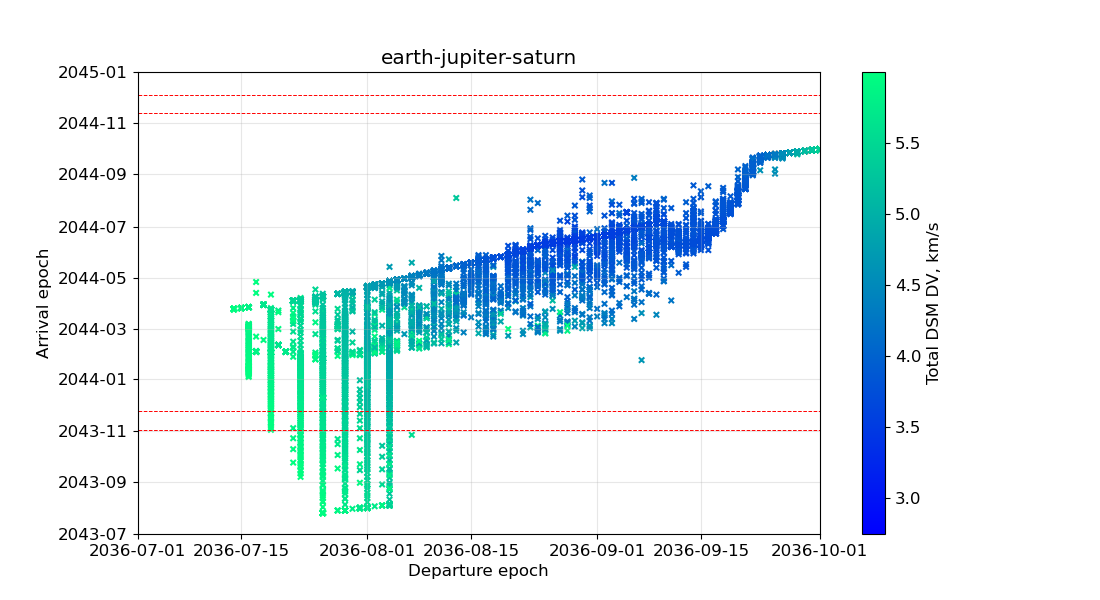

In [29]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(11,6))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], 
                 porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
                 c=porkchop_return['dsm_total']/1e3, 
                 cmap='winter', s=15, marker='x', 
                 vmin=min(porkchop_return['dsm_total'])/1e3,
                 vmax=max(porkchop_return['dsm_total'])/1e3
)

# blackout windows
for blackout in pxp.blackout_window_2040s():
    ax.hlines(
        [
            blackout[0], blackout[1]
        ],
        min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), 
        color="red", linestyle="--", linewidth=0.7,
    )

fig.colorbar(im0, label='Total DSM DV, km/s')#, ticks=[el for el in range(11)])
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="Arrival epoch")
ax.grid(True, alpha=0.3)
ax.set_xlim([
    datetime.datetime.strptime("2036-07-01", '%Y-%m-%d'),
    datetime.datetime.strptime("2036-10-01", '%Y-%m-%d')
])
ax.set_ylim([
    datetime.datetime.strptime("2043-07-01", '%Y-%m-%d'),
    datetime.datetime.strptime("2045-01-01", '%Y-%m-%d')
])

plt.show()

In [30]:
#plt.savefig("./plots/seq_"+seq_name+"_dsm_dv_zoom.png")

In [31]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1,figsize=(11,6))

# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
#                      c=porkchop_return['launch_deltaV']/1e3, cmap=cm.dense, s=15, marker='x')

# # blackout windows
# for blackout in pxp.blackout_window_2040s():
#     ax.hlines(
#         [
#             blackout[0], blackout[1]
#         ],
#         min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), 
#         color="red", linestyle="--", linewidth=0.7,
#     )

# fig.colorbar(im0, label='Launch v-infinity, km/s')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure epoch", ylabel="Arrival epoch")
# ax.grid(True, alpha=0.3)

# plt.show()

In [32]:
#plt.savefig("./plots/seq_"+seq_name+"_vinf_arr.png")

<IPython.core.display.Javascript object>


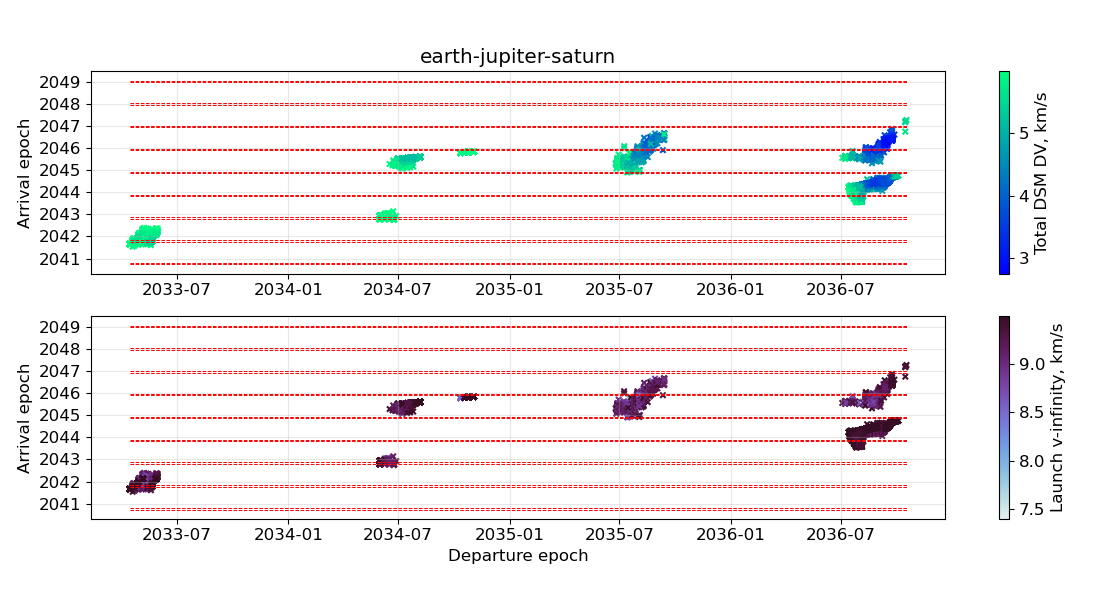

In [33]:
plt.rcParams["font.size"] = 12

fig, axs = plt.subplots(2,1,figsize=(11,6))

im0 = axs[0].scatter(porkchop_return['t0_matplotlib'], 
                 porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
                 c=porkchop_return['dsm_total']/1e3, 
                 cmap='winter', s=15, marker='x', 
                 vmin=min(porkchop_return['dsm_total'])/1e3,
                 vmax=max(porkchop_return['dsm_total'])/1e3
)

# blackout windows
for blackout in pxp.blackout_window_2040s():
    axs[0].hlines(
        [
            blackout[0], blackout[1]
        ],
        min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), 
        color="red", linestyle="--", linewidth=0.7,
    )

fig.colorbar(im0, label='Total DSM DV, km/s', ax=axs[0])#, ticks=[el for el in range(11)])
axs[0].set_title(seq_name)
axs[0].set(ylabel="Arrival epoch")
axs[0].grid(True, alpha=0.3)


## Second plot
im1 = axs[1].scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
                     c=porkchop_return['launch_deltaV']/1e3, cmap=cm.dense, s=15, marker='x')

# blackout windows
for blackout in pxp.blackout_window_2040s():
    axs[1].hlines(
        [
            blackout[0], blackout[1]
        ],
        min(porkchop_return['t0_matplotlib']), max(porkchop_return['t0_matplotlib']), 
        color="red", linestyle="--", linewidth=0.7,
    )

fig.colorbar(im1, label='Launch v-infinity, km/s', ax=axs[1])
axs[1].set(xlabel="Departure epoch", ylabel="Arrival epoch")
axs[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1.07, 0.95])  # [left, bottom, right, top]
plt.show()

In [34]:
#fig.savefig("./plots/interplanetar_outbound_windows_seq_"+seq_name+"_vinf_arr.png")

In [35]:
prob_test_no_vinf_dep.fitness(pareto_sols["min_dsm"])[0]/1e3

NameError: name 'pareto_sols' is not defined

### Trajectory plot

In [36]:
earth_coord = pxp.coord_planet(ssdict["earth"], t0, 6000)
jup_coord   = pxp.coord_planet(ssdict["jupiter"], t0, 6000)
sat_coord   = pxp.coord_planet(ssdict["saturn"], t0, 6000)

NameError: name 't0' is not defined

In [ ]:
coord, dsm_info, traj_comp = pxp.coord_mga_1dsm(prob_test, best_sol[0], 86400)

In [ ]:
len(traj_comp)

In [ ]:
traj_comp#[2]

In [ ]:
prob_test.pretty(best_sol[0])

In [ ]:
earth_coord = pxp.coord_planet(ssdict["earth"], t0, 6000)
jup_coord   = pxp.coord_planet(ssdict["jupiter"], t0, 6000)
sat_coord   = pxp.coord_planet(ssdict["saturn"], t0, 6000)

plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(8,6))

# trajectory
ax.plot(coord[1,:]/pk.AU, coord[2,:]/pk.AU, c="black", lw=1.2)

ax.scatter(earth_coord[0,0]/pk.AU, earth_coord[1,0]/pk.AU, c="#86DDC8", zorder=3,
          label="Earth departure, 2036-08-28")
ax.scatter(traj_comp[2][0][0]/pk.AU, traj_comp[2][0][1]/pk.AU, c="#605D74", zorder=3,
          label="Jupiter fly-by, 2040-01-06")
ax.scatter(coord[1,-1]/pk.AU, coord[2,-1]/pk.AU, c="#F4AB07", zorder=3,
          label="Saturn SOI, 2044-07-07")

# planets
ax.plot(earth_coord[0,:]/pk.AU, earth_coord[1,:]/pk.AU, c="#86DDC8", lw=1.0, ls="--", label="Earth orbit")
ax.plot(jup_coord[0,:]/pk.AU, jup_coord[1,:]/pk.AU, c="#605D74", lw=1.0, ls="--", label="Jupiter")
ax.plot(sat_coord[0,:]/pk.AU, sat_coord[1,:]/pk.AU, c="#F4AB07", lw=1.0, ls="--", label="Saturn")

# DSMs
# for i,dsm in enumerate(dsm_info):
#     ax.scatter(dsm[0][0]/pk.AU, dsm[0][1]/pk.AU, marker="x", label=f"DSM {i+1}")
ax.scatter(dsm_info[0][0][0]/pk.AU, dsm_info[0][0][1]/pk.AU, 
           marker="x", label=f"DSM {1}, 2037-07-09")
ax.scatter(dsm_info[1][0][0]/pk.AU, dsm_info[1][0][1]/pk.AU, 
           marker="x", label=f"DSM {1}, 2040-06-18")

ax.set(xlabel="x, AU", ylabel="y, AU")
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim([-12,26])
ax.set_ylim([-12,12])
ax.legend()

plt.tight_layout(rect=[0, -0.0, 1, 1.0])
plt.show()

In [ ]:
#fig.savefig("./plots/nominal_outbound_interplanetary_traj.png")

In [ ]:
coord, dsm_info = pxp.coord_mga_1dsm(prob_test, best_sol[0], 86400)

earth_coord = pxp.coord_planet(ssdict["earth"], t0, 6000)
jup_coord   = pxp.coord_planet(ssdict["jupiter"], t0, 6000)
sat_coord   = pxp.coord_planet(ssdict["saturn"], t0, 6000)

plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(8,6))

# trajectory
ax.plot(coord[1,:]/pk.AU, coord[2,:]/pk.AU, c="deeppink", lw=0.75)

# planets
ax.plot(earth_coord[0,:]/pk.AU, earth_coord[1,:]/pk.AU, c="#605D74", lw=0.8, ls="--", label="Earth orbit")
ax.plot(jup_coord[0,:]/pk.AU, jup_coord[1,:]/pk.AU, c="#86DDC8", lw=0.8, ls="--", label="Jupiter")
ax.plot(sat_coord[0,:]/pk.AU, sat_coord[1,:]/pk.AU, c="#F4AB07", lw=0.8, ls="--", label="Saturn")

ax.set_xlabel("x, AU", color='gainsboro')
ax.set_ylabel("y, AU", color='gainsboro')
ax.tick_params(colors='gainsboro')

#ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax.set_alpha(0.01)

ax.set_facecolor("#041036")
fig.set_facecolor("#041036")
    
ax.grid(True, alpha=0.3, color='gainsboro')
ax.set_aspect('equal')
#plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='red')
ax.spines['bottom'].set_color('gainsboro')
ax.spines['top'].set_color('gainsboro')
ax.spines['left'].set_color('gainsboro')
ax.spines['right'].set_color('gainsboro')

plt.show()

### Index of solution

In [ ]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1,figsize=(11,4))

# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
#                      c=porkchop_return['idx'], cmap='plasma', s=15, marker='x')

# fig.colorbar(im0, label='Index')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure, year", ylabel="TOF, year")

# plt.show()